In [9]:
import pandas as pd

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
import PIL.Image
import PIL.ImageOps

import numpy as np

In [10]:
CSVPATH = "./csv/Cyril/"
TXTPATH = "./txt/Cyril/"
IMAGESPATH = "./images/Cyril/"
CORRIMAGESPATH = "./images_corrected/Cyril/"
files = os.listdir(CSVPATH)

categ = {"pant":0,"skirt":1,"dress":2,"shoes":3,"hat":4,"coat":5,"shirt":6,"pull":7}

In [14]:
def exif_transpose(img):
    if not img:
        return img

    exif_orientation_tag = 274
    orientation = 1
    # Check for EXIF data (only present on some files)
    if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
        exif_data = img._getexif()
        orientation = exif_data[exif_orientation_tag]
        # Handle EXIF Orientation
        if orientation == 1:
            # Normal image - nothing to do!
            pass
        elif orientation == 2:
            # Mirrored left to right
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            # Rotated 180 degrees
            img = img.rotate(180)
        elif orientation == 4:
            # Mirrored top to bottom
            img = img.rotate(180).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            # Mirrored along top-left diagonal
            img = img.rotate(-90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            # Rotated 90 degrees
            img = img.rotate(-90, expand=True)
        elif orientation == 7:
            # Mirrored along top-right diagonal
            img = img.rotate(90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            # Rotated 270 degrees
            img = img.rotate(90, expand=True)
    return orientation, img

def box_transpose(orientation, x, y, w, h, im_w, im_h):
    # need to modify boxes coordinates to reflect orientation.
    cx = x
    cy = y
    cw = w
    ch = h
    cim_w = im_w
    cim_h = im_h
    # Handle EXIF Orientation
    if orientation == 1:
        # Normal image - nothing to do!
        pass
    elif orientation == 3:
        # Rotated 180 degrees
        cx = im_w - (x + w)
        cy = im_h - (y + h)
    elif orientation == 6:
        # Rotated 90 degrees
        cx = im_w - (y + h)
        cy = x
        cw = h
        ch = w
    elif orientation == 8:
        # Rotated 270 degrees
        cx = y
        cy = im_h - (x + w)
        cw = h
        ch = w
    else:
        print("orientation %d not managed" % orientation)
        
    return cx, cy, cw, ch , cim_w, cim_h

def load_image_file(file, mode='RGB'):
    # Load the image with PIL
    img = PIL.Image.open(file)
    orientation, img = exif_transpose(img)
    img = img.convert(mode)
    npimg = np.array(img)
    return orientation, npimg

In [17]:
def annotation_csv_to_txt():
    """
    transform csv files obtained with vgg annotator
    to txt files to be consumed by yolo for training.
    create a txt file per picture with same name
    format in txt file <class> <xcenter> <ycenter> <width> <height>
    values in txt files are float realtive to image width and height.
    """
    for file in files:
        try:
            mypd = pd.read_csv(os.path.join(CSVPATH,file))
            print("file: %s" % file)
        except Exception as e:
            print("Error reading file: %s --> " % file,e)
        else:
            for f in mypd.filename.unique():
                root,ext = os.path.splitext(f)
                orientation, img = load_image_file(os.path.join(IMAGESPATH,f))
                im_h, im_w, im_lev = img.shape

                # save image with correct orientation in images_corrected folder
                img = Image.fromarray(img, 'RGB')
                img.save(os.path.join(CORRIMAGESPATH,f))

                output = []
                for idx,line in mypd[mypd['filename']==f].iterrows():
                    mydict = eval(line.region_shape_attributes)
                    x=mydict['x']
                    y=mydict['y']
                    w=mydict['width']
                    h=mydict['height']

                    cx, cy, cw, ch , cim_w, cim_h = box_transpose(orientation, x, y, w, h, im_w, im_h)

                    mylabeldict = eval(line.region_attributes)
                    cat = categ[mylabeldict['clothe']]

                    xcenter = (cx + cw / 2) / cim_w
                    ycenter = (cy + ch / 2) / cim_h
                    dwidth = cw / cim_w
                    dheight = ch / cim_h
                    output.append([cat,xcenter,ycenter,dwidth,dheight])

                outputf = pd.DataFrame(output)
                outputf.to_csv(os.path.join(TXTPATH,root+".txt"),index=False,header=False,sep=" ")
                print("files: %s.txt created" % root)

In [22]:
annotation_csv_to_txt()

file: via_export_csv.csv
files: 127-2737_IMG.txt created
files: 127-2738_IMG.txt created
files: 128-2881_IMG.txt created
files: 150121.txt created
file: via_export_csv_(1).csv
files: DSC07195.txt created
files: DSC07199.txt created
files: IMG_0661.txt created
files: IMG_20160719_091142.txt created
file: via_export_csv_(10).csv
files: IMG_20200307_130617.txt created
files: IMG_20200307_130619.txt created
files: IMG_20200307_130621.txt created
files: IMG_20200307_130622.txt created
file: via_export_csv_(11).csv
files: IMG_20200307_130700.txt created
files: IMG_20200307_130701.txt created
files: IMG_20200307_130705.txt created
files: J2 chanteuges 10.txt created
file: via_export_csv_(12).csv
files: P1010030.txt created
files: P1030886.txt created
files: P1030890.txt created
files: P1160982.txt created
file: via_export_csv_(13).csv
files: P1160984.txt created
files: Photo 246.txt created
files: Photo 303.txt created
files: Rome_2009_ 006.txt created
file: via_export_csv_(14).csv
files: Rom

In [23]:
def checkboxes_from_txt_files(filename):
    mypd = pd.read_csv(os.path.join(TXTPATH,filename+".txt"),sep=" ",header=None)
    image = mpimg.imread(os.path.join(CORRIMAGESPATH,filename+".jpg")) 
    im_h, im_w , lev = image.shape
    plt.rcParams["figure.figsize"] = (10,10)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for idx, line in mypd.iterrows():
        xcenter = line[1] * im_w
        ycenter= line[2] * im_h
        width = line[3] * im_w
        height = line[4] * im_h
        x = (xcenter-width/2)
        y = (ycenter-height/2)
        w = width 
        h = height
        rect = patches.Rectangle((x,y),w,h,edgecolor='r',facecolor='none')
        c = [key  for (key, value) in categ.items() if value == line[0]]
        plt.text(x, y, c[0], color='red', fontsize=15)
        ax.add_patch(rect)
    
    plt.show()

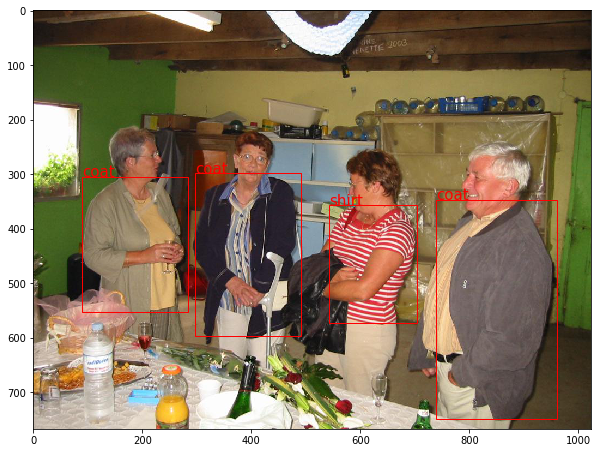

In [24]:
filename = '127-2737_IMG'
checkboxes_from_txt_files(filename)

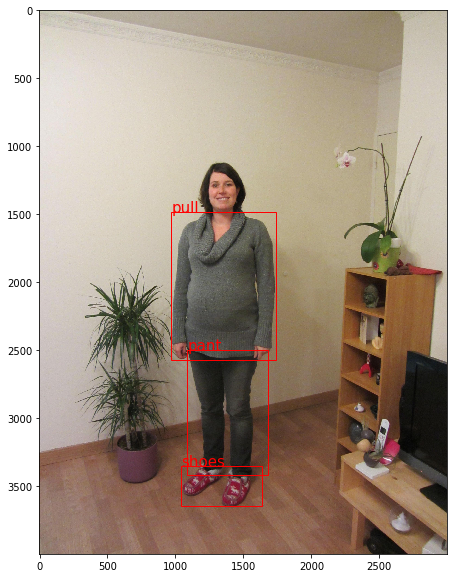

In [25]:
filename = '150121'
checkboxes_from_txt_files(filename)